## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Import Data

In [26]:
mta_df = pd.read_csv("./Turnstile_Usage_Data__2017.csv")

## Convert to Datetime Object

In [27]:
mta_df['Datetime'] = pd.to_datetime(mta_df['Date'] + mta_df['Time'], 
                                  format='%m/%d/%Y%H:%M:%S')

## Select timeframe (if applicable)

In [28]:
start_date = '20170101'
end_date = '20170201'
mta_df = mta_df[(mta_df['Datetime'] > start_date) & (mta_df['Datetime'] < end_date) ]

In [29]:
mta_df[(mta_df['Station'] == top20_station[0]) & (mta_df['Date'] == '01/22/2017')]

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits,Datetime
636619,N078,R175,01-00-00,14 ST,ACEL,IND,01/22/2017,00:00:00,REGULAR,4878519,6205807,2017-01-22 00:00:00
636620,N078,R175,01-00-00,14 ST,ACEL,IND,01/22/2017,04:00:00,REGULAR,4878591,6205854,2017-01-22 04:00:00
636621,N078,R175,01-00-00,14 ST,ACEL,IND,01/22/2017,08:00:00,REGULAR,4878629,6205900,2017-01-22 08:00:00
636622,N078,R175,01-00-00,14 ST,ACEL,IND,01/22/2017,12:00:00,REGULAR,4878743,6206186,2017-01-22 12:00:00
636623,N078,R175,01-00-00,14 ST,ACEL,IND,01/22/2017,16:00:00,REGULAR,4879005,6206584,2017-01-22 16:00:00
636624,N078,R175,01-00-00,14 ST,ACEL,IND,01/22/2017,20:00:00,REGULAR,4879343,6206866,2017-01-22 20:00:00
636661,N078,R175,01-00-01,14 ST,ACEL,IND,01/22/2017,00:00:00,REGULAR,167666,316100,2017-01-22 00:00:00
636662,N078,R175,01-00-01,14 ST,ACEL,IND,01/22/2017,04:00:00,REGULAR,167719,316136,2017-01-22 04:00:00
636663,N078,R175,01-00-01,14 ST,ACEL,IND,01/22/2017,08:00:00,REGULAR,167749,316161,2017-01-22 08:00:00
636664,N078,R175,01-00-01,14 ST,ACEL,IND,01/22/2017,12:00:00,REGULAR,167803,316357,2017-01-22 12:00:00


## Add a column of day_of_week and a column of holiday

In [5]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

mta_df['Day'] = mta_df['Datetime'].dt.dayofweek

cal = calendar()
holidays = cal.holidays(start=mta_df.Date.min(), end=mta_df.Date.max())

mta_df['Holiday'] = mta_df['Date'].isin(holidays)

## Calculate Entries in Each Time Interval

In [6]:
# sort records by C/A, Unit, SCP, and Station for calculation
mta_df = mta_df.sort_values(['C/A', 'Unit', 'SCP', 'Station'])

# create columns of C/A, Unit, SCP, and Station with one row shift down
mta_df['Entries_shifted'] = mta_df['Entries'].shift(1)
mta_df['C/A_shifted'] = mta_df['C/A'].shift(1)
mta_df['Unit_shifted'] = mta_df['Unit'].shift(1)
mta_df['SCP_shifted'] = mta_df['SCP'].shift(1)
mta_df['Station_shifted'] = mta_df['Station'].shift(1)
mta_df['Previous_Datetime'] = mta_df['Datetime'].shift(1)

# only calcuate the entries difference if C/A, Unit, SCP, and Station are same
cond = (mta_df['C/A_shifted'] == mta_df['C/A'])\
        &(mta_df['Unit_shifted'] == mta_df['Unit'])\
        &(mta_df['SCP_shifted'] == mta_df['SCP'])\
        &(mta_df['Station_shifted'] == mta_df['Station'])

mta_df['Entries_4_hours'] = mta_df['Entries'] - mta_df['Entries_shifted'] 
mta_df['Entries_4_hours_cleaned'] = np.where(cond, mta_df['Entries_4_hours'], 0)

In [7]:
# drop shifted columns

mta_df = mta_df.drop(['C/A_shifted', 'Unit_shifted', 'SCP_shifted', 'Station_shifted', 'Entries_shifted'], axis=1)

### There are still rows with negative entries number, need to decide what to do with them

In [8]:
# drop record with negative entries every 4 hours
mta_df = mta_df[mta_df['Entries_4_hours_cleaned'] > 0]

## Total number of turnstile

In [9]:
mta_df.groupby(['C/A','Unit', 'SCP', 'Station'])['Entries_4_hours_cleaned'].sum().count()

4334

## total number of station

In [10]:
mta_df.groupby(['Station'])['Entries_4_hours_cleaned'].sum().count()

372

## Statistic Summary of Cleaned Entries Every 4 Hours

In [11]:
# explore entries distribution
mta_df['Entries_4_hours_cleaned'].describe()

count    7.253770e+05
mean     6.828688e+03
std      3.008830e+06
min      1.000000e+00
25%      2.900000e+01
50%      1.040000e+02
75%      2.670000e+02
max      2.122193e+09
Name: Entries_4_hours_cleaned, dtype: float64

## distribution of entries in every 4 hours at a turnstile

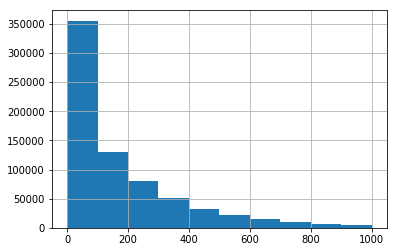

In [12]:
mta_df['Entries_4_hours_cleaned'].hist(range=[0, 1e3])

## distribution of daily entries at a turnstile

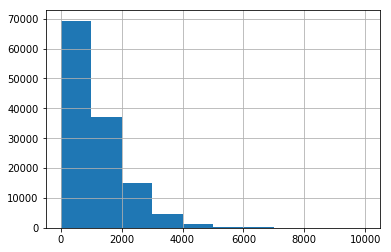

In [13]:
#mta_df.groupby(['C/A','Unit', 'SCP', 'Station', 'Date'])['Entries_4_hours_cleaned'].sum()
mta_df.groupby(['C/A','Unit', 'SCP', 'Station','Date'])['Entries_4_hours_cleaned'].sum().hist(range=[0, 1e4])

## distribution of daily entries at a station

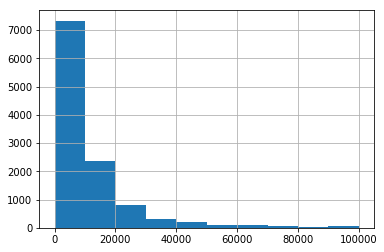

In [14]:
mta_df.groupby(['Station','Date'])['Entries_4_hours_cleaned'].sum().hist(range=[0, 1e5])

## distribution of sum of entries on a day of the week at a station

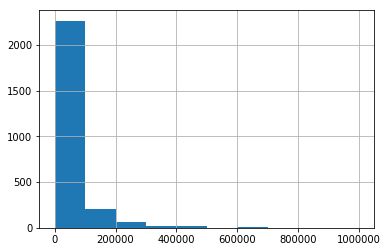

In [16]:
#mta_df.groupby(['Station', 'day'], as_index=False)['Entries_4_hours_cleaned'].sum()

mta_df.groupby(['Station', 'Day'])['Entries_4_hours_cleaned'].sum().hist(range=[0,1e6])

In [17]:
top20_station = (list(mta_df.groupby(['Station'])['Entries_4_hours_cleaned']
                      .sum().sort_values(ascending=False).head(20).index)
                )
top20_station

['14 ST',
 'CHAMBERS ST',
 'HIGH ST',
 'CORTLANDT ST',
 'CLINTON-WASH AV',
 '34 ST-PENN STA',
 '15 ST-PROSPECT',
 'CANAL ST',
 '14 ST-UNION SQ',
 '225 ST',
 '53 ST',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 '23 ST',
 'THIRTY THIRD ST',
 'TIMES SQ-42 ST',
 '86 ST',
 '42 ST-PORT AUTH',
 'FULTON ST',
 '125 ST']

In [25]:
mta_df[(mta_df['Station'] == top20_station[0]) & (mta_df['Date'] == '01/22/2017')]

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits,Datetime,Day,Holiday,Previous_Datetime,Entries_4_hours,Entries_4_hours_cleaned
636619,N078,R175,01-00-00,14 ST,ACEL,IND,01/22/2017,00:00:00,REGULAR,4878519,6205807,2017-01-22 00:00:00,6,False,2017-01-21 20:00:00,2.270000e+02,2.270000e+02
636620,N078,R175,01-00-00,14 ST,ACEL,IND,01/22/2017,04:00:00,REGULAR,4878591,6205854,2017-01-22 04:00:00,6,False,2017-01-22 00:00:00,7.200000e+01,7.200000e+01
636621,N078,R175,01-00-00,14 ST,ACEL,IND,01/22/2017,08:00:00,REGULAR,4878629,6205900,2017-01-22 08:00:00,6,False,2017-01-22 04:00:00,3.800000e+01,3.800000e+01
636622,N078,R175,01-00-00,14 ST,ACEL,IND,01/22/2017,12:00:00,REGULAR,4878743,6206186,2017-01-22 12:00:00,6,False,2017-01-22 08:00:00,1.140000e+02,1.140000e+02
636623,N078,R175,01-00-00,14 ST,ACEL,IND,01/22/2017,16:00:00,REGULAR,4879005,6206584,2017-01-22 16:00:00,6,False,2017-01-22 12:00:00,2.620000e+02,2.620000e+02
636624,N078,R175,01-00-00,14 ST,ACEL,IND,01/22/2017,20:00:00,REGULAR,4879343,6206866,2017-01-22 20:00:00,6,False,2017-01-22 16:00:00,3.380000e+02,3.380000e+02
636661,N078,R175,01-00-01,14 ST,ACEL,IND,01/22/2017,00:00:00,REGULAR,167666,316100,2017-01-22 00:00:00,6,False,2017-01-21 20:00:00,1.410000e+02,1.410000e+02
636662,N078,R175,01-00-01,14 ST,ACEL,IND,01/22/2017,04:00:00,REGULAR,167719,316136,2017-01-22 04:00:00,6,False,2017-01-22 00:00:00,5.300000e+01,5.300000e+01
636663,N078,R175,01-00-01,14 ST,ACEL,IND,01/22/2017,08:00:00,REGULAR,167749,316161,2017-01-22 08:00:00,6,False,2017-01-22 04:00:00,3.000000e+01,3.000000e+01
636664,N078,R175,01-00-01,14 ST,ACEL,IND,01/22/2017,12:00:00,REGULAR,167803,316357,2017-01-22 12:00:00,6,False,2017-01-22 08:00:00,5.400000e+01,5.400000e+01


In [22]:
mta_df[mta_df['Station'] == top20_station[0]].groupby(['Date'])['Entries_4_hours_cleaned'].sum()

Date
01/01/2017    2.037700e+04
01/02/2017    2.906900e+04
01/03/2017    5.509400e+04
01/04/2017    6.080000e+04
01/05/2017    6.041800e+04
01/06/2017    6.033400e+04
01/07/2017    3.359900e+04
01/08/2017    2.623200e+04
01/09/2017    5.437000e+04
01/10/2017    5.982300e+04
01/11/2017    6.071600e+04
01/12/2017    6.157300e+04
01/13/2017    6.176900e+04
01/14/2017    3.569700e+04
01/15/2017    2.893900e+04
01/16/2017    3.531500e+04
01/17/2017    5.812500e+04
01/18/2017    6.037800e+04
01/19/2017    6.197500e+04
01/20/2017    6.053100e+04
01/21/2017    3.297700e+04
01/22/2017    2.122217e+09
01/23/2017    5.139800e+04
01/24/2017    5.652800e+04
01/25/2017    6.079400e+04
01/26/2017    6.072600e+04
01/27/2017    5.992300e+04
01/28/2017    3.665800e+04
01/29/2017    2.919800e+04
01/30/2017    5.434500e+04
01/31/2017    5.913900e+04
Name: Entries_4_hours_cleaned, dtype: float64